In [1]:
import datetime
import warnings
import scipy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
import sklearn

from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec

from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn import metrics, linear_model


%matplotlib inline

warnings.filterwarnings("ignore")


In [2]:
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

# from IPython.core.interactiveshell import InteractiveShell

# from collections import OrderedDict

# InteractiveShell.ast_node_interactivity = "last_expr"

# pd.options.display.max_columns = 50


In [3]:
df = pd.read_csv('flights.jan.csv')


In [4]:
print('Dimensões do dataframe: ', df.shape)


Dimensões do dataframe:  (469968, 32)


# Limpeza


In [5]:
# informações de valores nulos e tipos das colunas

tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'tipo de dado'})

tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(
    index={0: 'valores nulos (contagem)'}))

tab_info = tab_info.append(pd.DataFrame(
    df.isnull().sum()/df.shape[0]*100).T.rename(index={0: 'valores nulos (%)'}))
tab_info


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
tipo de dado,int64,int64,int64,int64,int64,object,int64,object,object,object,...,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
valores nulos (contagem),0,0,0,0,0,0,0,2782,0,0,...,12271,12955,0,0,457986,374017,374017,374017,374017,374017
valores nulos (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591955,0.0,0.0,...,2.611029,2.756571,0.0,0.0,97.450465,79.583504,79.583504,79.583504,79.583504,79.583504


In [6]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])


In [7]:
# Função que converte a string 'HHMM' em datetime.time

def formatar_horario(dado_orig):
    if pd.isnull(dado_orig):
        return np.nan
    else:
        if dado_orig == 2400:
            dado_orig = 0
        dado_orig = "{0:04d}".format(int(dado_orig))
        horario = datetime.time(int(dado_orig[0:2]), int(dado_orig[2:4]))
        return horario


# Função que combina a data e o horario para criar um datetime.datetime

def combinar_data_horario(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0], x[1])


# Função que combina duas colunas do dataframe para criar um formato datetime

def criar_horario_voo(df, col):
    lista = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            lista.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0, 0)
            lista.append(combinar_data_horario(cols))
        else:
            cols[1] = formatar_horario(cols[1])
            lista.append(combinar_data_horario(cols))
    return pd.Series(lista)


In [8]:
df['SCHEDULED_DEPARTURE'] = criar_horario_voo(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(formatar_horario)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(formatar_horario)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(formatar_horario)


In [9]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
            'DEPARTURE_TIME', 'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]


,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [10]:
a_remover = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DATE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
             'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME', 'Unnamed: 0']

df.drop(a_remover, axis=1, inplace=True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
         'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME']]

df[:5]


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [11]:
valores_faltantes_df = df.isnull().sum(axis=0).reset_index()
valores_faltantes_df.columns = ['Variável', 'Valores faltantes']
valores_faltantes_df['Valores presentes (%)'] = (
    df.shape[0]-valores_faltantes_df['Valores faltantes'])/df.shape[0]*100
valores_faltantes_df.sort_values(
    'Valores presentes (%)').reset_index(drop=True)


,Variável,Valores faltantes,Valores presentes (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [12]:
df.dropna(inplace=True)


In [13]:
df.isnull().sum()


AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
SCHEDULED_TIME         0
ELAPSED_TIME           0
dtype: int64

# Comparando companhias aéreas


In [14]:
companhias_aereas = pd.read_csv('airlines.csv')
companhias_aereas


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [15]:
abrev_companhias = companhias_aereas.set_index('IATA_CODE')[
    'AIRLINE'].to_dict()


In [16]:
# Função que extrai parâmetros estatísticos a partir de um objeto groupby:

def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'contagem': group.count(), 'média': group.mean()}


In [17]:
# Criação de um dataframe com informações estatísticas de cada companhia:

estats_companhias = df['DEPARTURE_DELAY'].groupby(
    df['AIRLINE']).apply(get_stats).unstack()
estats_companhias = estats_companhias.sort_values('contagem')
estats_companhias


,min,max,contagem,média
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


## Gráficos


In [18]:
fonte = {'family': 'verdana', 'weight': 'bold', 'size': 15}
mpl.rc('font', **fonte)


In [19]:
# Extrair um subset de colunas e redefinir os nomes das companhias aéreas

df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abrev_companhias)


In [20]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen',
          'lightskyblue', 'lightcoral', 'yellowgreen', 'gold',
          'tomato', 'violet', 'aquamarine', 'chartreuse']


In [21]:
sns.set_style("darkgrid")


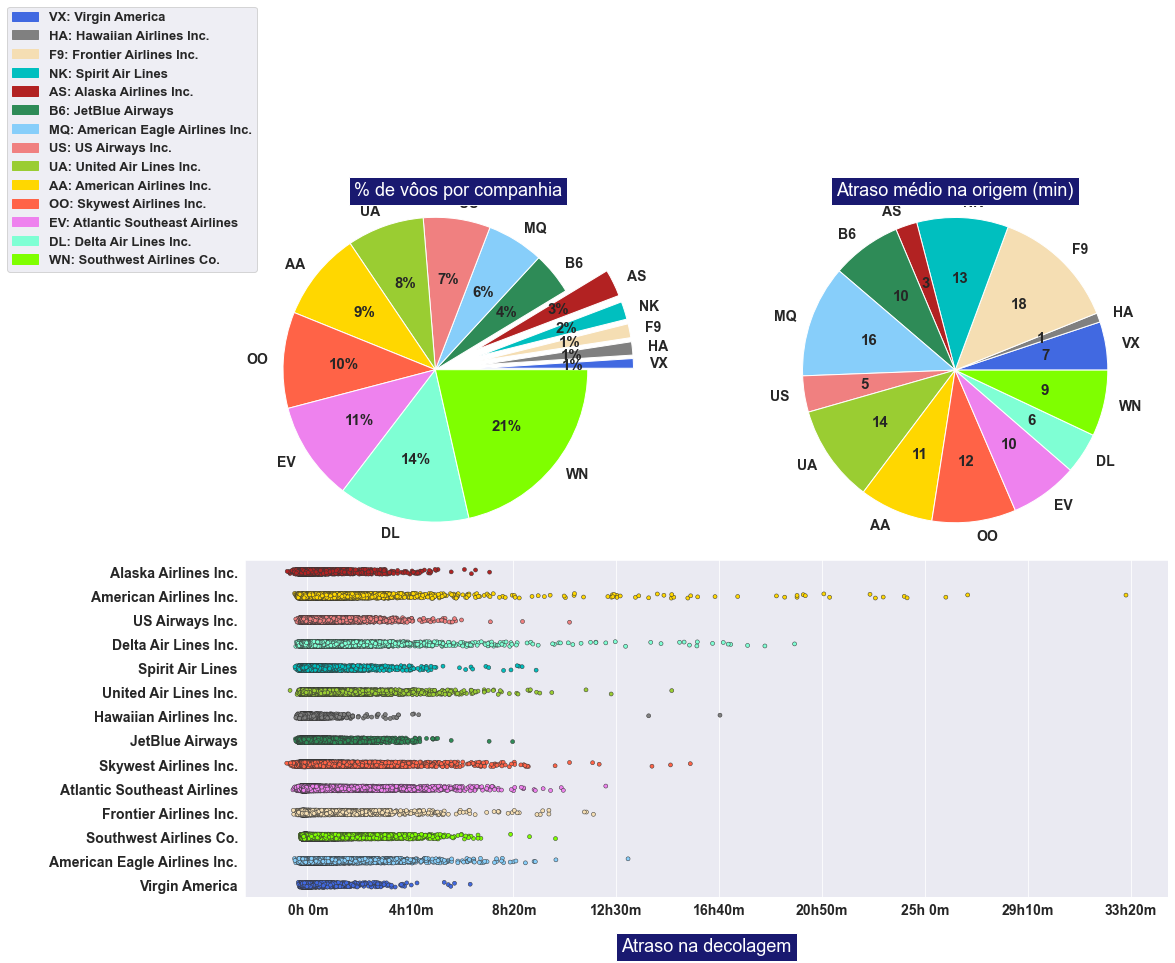

In [22]:
fig = plt.figure(1, figsize=(16, 15))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# --
# Gráfico de pizza 1: número de vôos

labels = [s for s in estats_companhias.index]
sizes = estats_companhias['contagem'].values
explode = [0.3 if sizes[i] < 20000
           else 0.0 for i in range(len(abrev_companhias))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                    labels=labels, colors=colors,
                                    autopct='%1.0f%%', shadow=False,
                                    startangle=0)

for i in range(len(abrev_companhias)):
    texts[i].set_fontsize(14)

ax1.axis('equal')
ax1.set_title('% de vôos por companhia',
              bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# --
# Colocando a legenda: abreviação -> nome da companhia aérea

comp_handler = []
for i in range(len(abrev_companhias)):
    comp_handler.append(mpatches.Patch(color=colors[i],
                                       label=estats_companhias.index[i] + ': ' + abrev_companhias[estats_companhias.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9),
           fontsize=13, bbox_transform=plt.gcf().transFigure)

# --
# Gráfico de pizza 2: atraso médio ao decolar

sizes = estats_companhias['média'].values
sizes = [max(s, 0) for s in sizes]
explode = [0.0 if sizes[i] < 20000
           else 0.01 for i in range(len(abrev_companhias))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode,
                                    labels=labels, colors=colors,
                                    shadow=False, startangle=0,
                                    autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abrev_companhias)):
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Atraso médio na origem (min)',
              bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# --
# Strip plot com todos os valores reportados para atrasos
# Redefinindo as cores para corresponder com os gráficos de pizza

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c',
          'yellowgreen', 'grey', 'seagreen', 'tomato', 'violet',
          'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

# --

ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size=4,
                    palette=colors, data=df2, linewidth=0.5,
                    jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(
    *[int(y) for y in divmod(x, 60)])
    for x in ax3.get_xticks()])
plt.xlabel('Atraso na decolagem', fontsize=18,
           bbox={'facecolor': 'midnightblue', 'pad': 5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# --

plt.tight_layout(w_pad=3)


In [23]:
# Função que define como atrasos são agrupados

def tipo_atraso(x): return ((0, 1)[x > 5], 2)[x > 45]


df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(tipo_atraso)


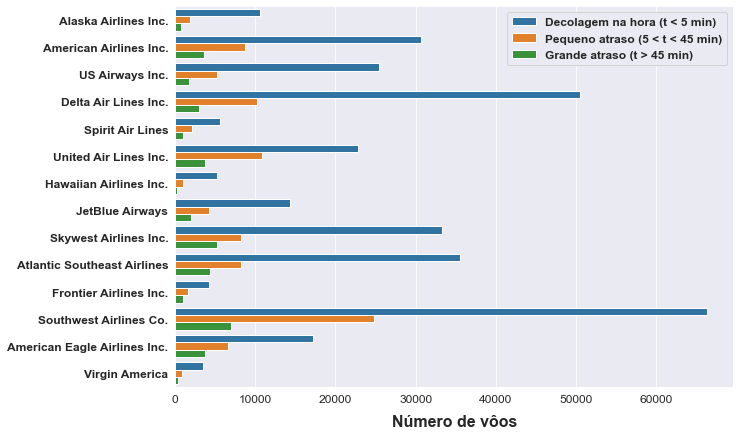

In [24]:
fig = plt.figure(1, figsize=(10, 7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)

# Substituindo as abreviações pelo nome completo das companhias aéreas e colocando os labels

labels = [abrev_companhias[item.get_text()]
          for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight='normal', rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight='bold', rotation=0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Número de vôos', fontsize=16, weight='bold', labelpad=10)


# Colocando a legenda

L = plt.legend(fontsize=12)
L.get_texts()[0].set_text('Decolagem na hora (t < 5 min)')
L.get_texts()[1].set_text('Pequeno atraso (5 < t < 45 min)')
L.get_texts()[2].set_text('Grande atraso (t > 45 min)')


plt.show()


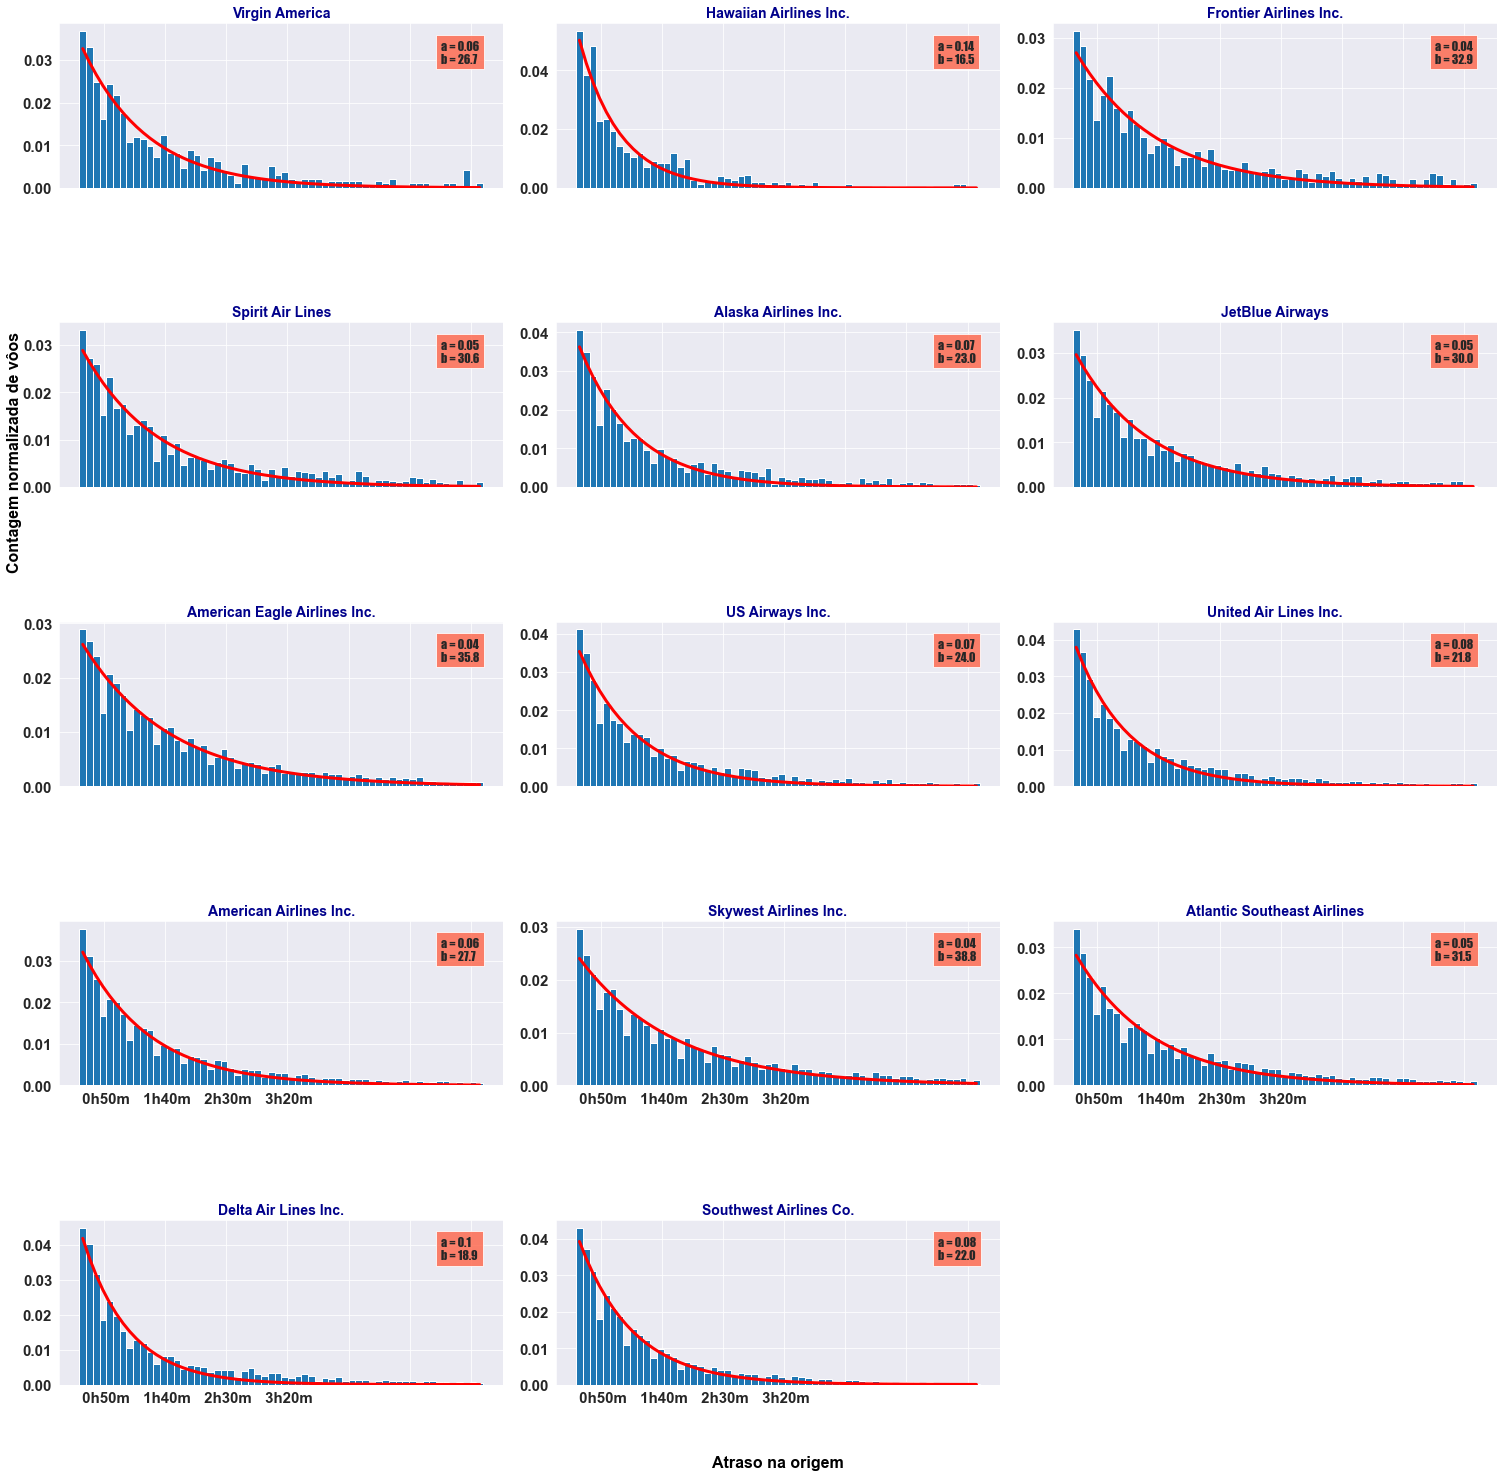

In [25]:
# Função modelo usada para fitar os histogramas
def fit_hist(x, a, b):
    return a * np.exp(-x/b)

# --


pontos = []
label_comp = []

fig = plt.figure(1, figsize=(21, 21))

i = 0
for nome_comp in [abrev_companhias[x] for x in estats_companhias.index]:
    i += 1
    ax = fig.add_subplot(5, 3, i)

    # Fitando a distribuição
    n, bins, patches = plt.hist(x=df2[df2['AIRLINE'] == nome_comp]
                                ['DEPARTURE_DELAY'], range=(15, 180),
                                density=True, bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(fit_hist, bin_centers, n, p0=[1, 2])

    # Contabilizando os resultados
    pontos.append(popt)
    label_comp.append(nome_comp)

    # Desenhando a curva fitada
    plt.plot(bin_centers, fit_hist(bin_centers, *popt), 'r-', linewidth=3)

    # Definindo as marcações em cada subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(
            *[int(y) for y in divmod(x, 60)])
            for x in ax.get_xticks()])

    # Título do subplot
    plt.title(nome_comp, fontsize=14, fontweight='bold', color='darkblue')

    # Labels dos eixos
    if i == 4:
        ax.text(-0.1, -0.5, 'Contagem normalizada de vôos', fontsize=16,
                rotation=90, color='k', horizontalalignment='center',
                transform=ax.transAxes)
    if i == 14:
        ax.text(0.5, -0.5, 'Atraso na origem', fontsize=16, rotation=0,
                color='k', horizontalalignment='center',
                transform=ax.transAxes)

    # Legenda: valores dos coeficientes a e b
    ax.text(0.86, 0.76, 'a = {}\nb = {}'.format(round(popt[0], 2),
            round(popt[1], 1)), style='italic', transform=ax.transAxes,
            fontsize=12, family='fantasy', bbox={'facecolor': 'tomato',
            'alpha': 0.8, 'pad': 5})

plt.tight_layout()


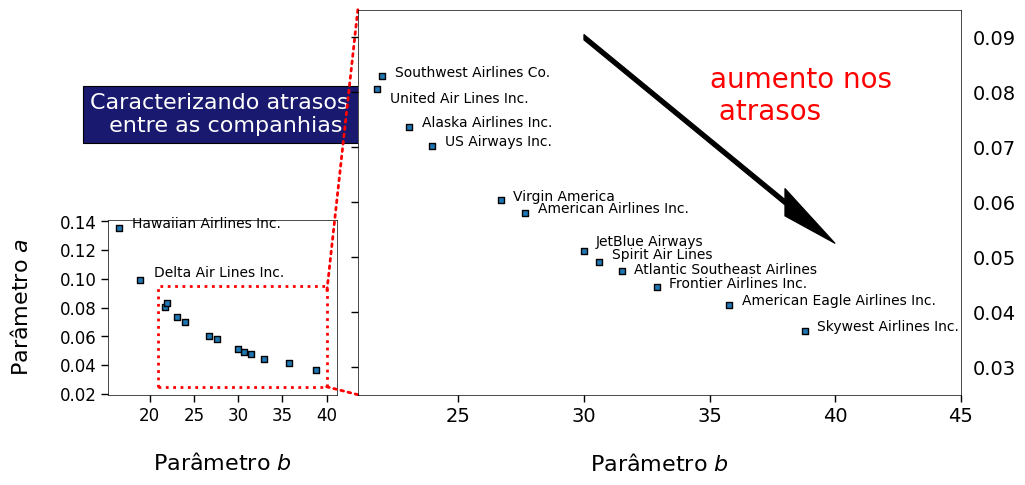

In [26]:
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_context('paper')

fig = plt.figure(1, figsize=(11, 5))

y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000

x_val = [s[1] for s in pontos]
y_val = [s[0] for s in pontos]

gs = GridSpec(2, 7)

# --
# 1) Plot overview (painel esquerdo)

ax1 = fig.add_subplot(gs[1, 0:2])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolor='black', linewidth=1)

# Label da companhia: Hawaiian airlines

i = 1
ax1.annotate(label_comp[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize=10)
plt.xlabel("Parâmetro $b$", fontsize=16, labelpad=20)
plt.ylabel("Parâmetro $a$", fontsize=16, labelpad=20)

# Label da companhia: Delta airlines

i = 12
ax1.annotate(label_comp[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize=10)
plt.xlabel("Parâmetro $b$", fontsize=16, labelpad=20)
plt.ylabel("Parâmetro $a$", fontsize=16, labelpad=20)

# Título principal

ax1.text(.5, 1.5, 'Caracterizando atrasos \n entre as companhias', fontsize=16,
         bbox={'facecolor': 'midnightblue', 'pad': 5}, color='w',
         horizontalalignment='center', transform=ax1.transAxes)

# Parâmetros das bordas do plot

for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')

# Criando um retângulo

rect = mpatches.Rectangle((21, 0.025), 19, 0.07, linewidth=2, edgecolor='r',
                          linestyle=':', facecolor='none')
ax1.add_patch(rect)

# --
# 2) Zoom no grosso das companhias (painel direito)

ax2 = fig.add_subplot(gs[0:2, 2:])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolor='black', linewidth=1)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21, 45)
ax2.set_ylim(0.025, 0.095)

# Labels das companhias

for i in range(len(abrev_companhias)):
    ax2.annotate(label_comp[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize=10)

# Direção de aumento dos atrasos

ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005, shape='full', head_length=2,
          fc='k', ec='k')
ax2.annotate('aumento nos \n atrasos', fontsize=20, color='r', xy=(35, 0.075),
             xycoords='data')

# Posição e tamanhos dos ticks

plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

# Parâmetros das bordas do plot

for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')

# Conexão entre os dois plots

xy2 = (40, 0.09)
xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data", axesA=ax2,
                      axesB=ax1, linestyle=':', linewidth=2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025)
xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data", axesA=ax2,
                      axesB=ax1, linestyle=':', linewidth=2, color="red")
ax2.add_artist(con)
plt.xlabel("Parâmetro $b$", fontsize=16, labelpad=20)

# --

plt.show()


# Atrasos: na decolagem ou no pouso?


Text(0.5, 0, 'Atraso médio em minutos\n(Na decolagem: azul; No pouso: linhas hachuradas)')

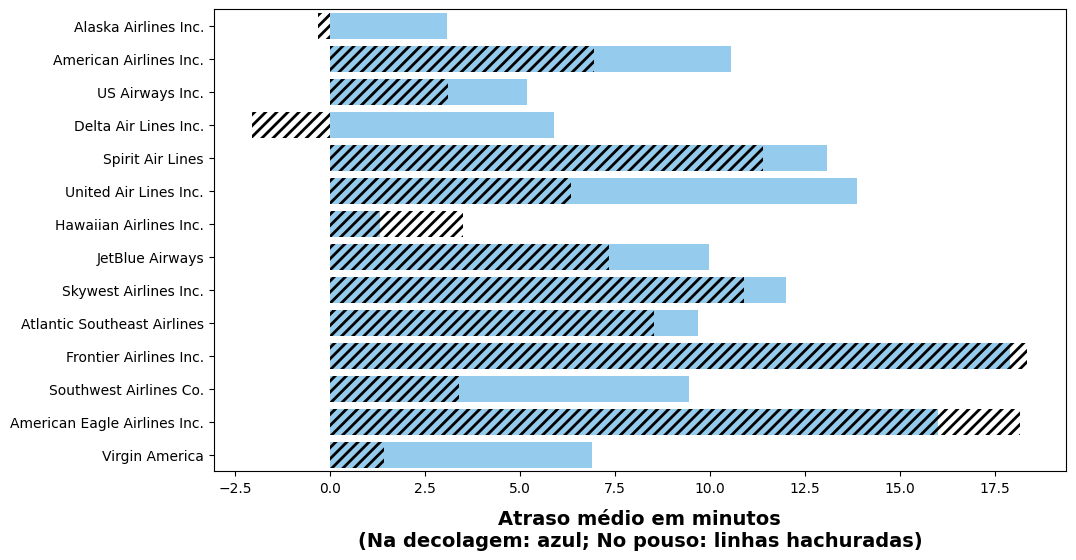

In [27]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

fig = plt.figure(1, figsize=(11, 6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue",
                 ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch='///',
                 alpha=0.0, ci=None)
labels = [abrev_companhias[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Atraso médio em minutos\n(Na decolagem: azul; No pouso: linhas hachuradas)',
           fontsize=14, weight='bold', labelpad=10)


# Relação entre o aeroporto de origem e os atrasos


In [28]:
print("Número de aeroportos: {}".format(len(df['ORIGIN_AIRPORT'].unique())))


Número de aeroportos: 312


In [29]:
num_origem = dict()
for comp in abrev_companhias.keys():
    list_aeroporto_origem = df[df['AIRLINE']
                               == comp]['ORIGIN_AIRPORT'].unique()
    num_origem[comp] = len(list_aeroporto_origem)


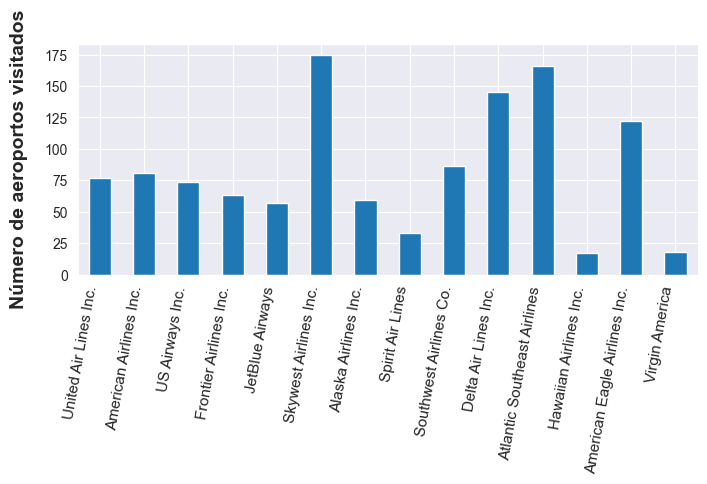

In [30]:
sns.set_style("darkgrid")

df_teste = pd.DataFrame.from_dict(num_origem, orient='index')
df_teste.rename(columns={0: 'contagem'}, inplace=True)

ax = df_teste.plot(kind='bar', figsize=(8, 3))

labels = [abrev_companhias[item.get_text()] for item in ax.get_xticklabels()]

ax.set_xticklabels(labels)
plt.ylabel('Número de aeroportos visitados', fontsize=14, weight='bold',
           labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha='right', rotation=80)

ax.legend().set_visible(False)

plt.show()


In [31]:
atraso_medio_aeroporto = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
atraso_medio_aeroporto.set_index(0, drop=True, inplace=True)

for comp in abrev_companhias.keys():
    df1 = df[df['AIRLINE'] == comp]
    teste = df1['DEPARTURE_DELAY'].groupby(
        df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    atraso_medio_aeroporto[comp] = teste.loc[:, 'média']


In [32]:
aeroportos = pd.read_csv('airports.csv')
id_aeroporto = aeroportos.set_index('IATA_CODE')['CITY'].to_dict()


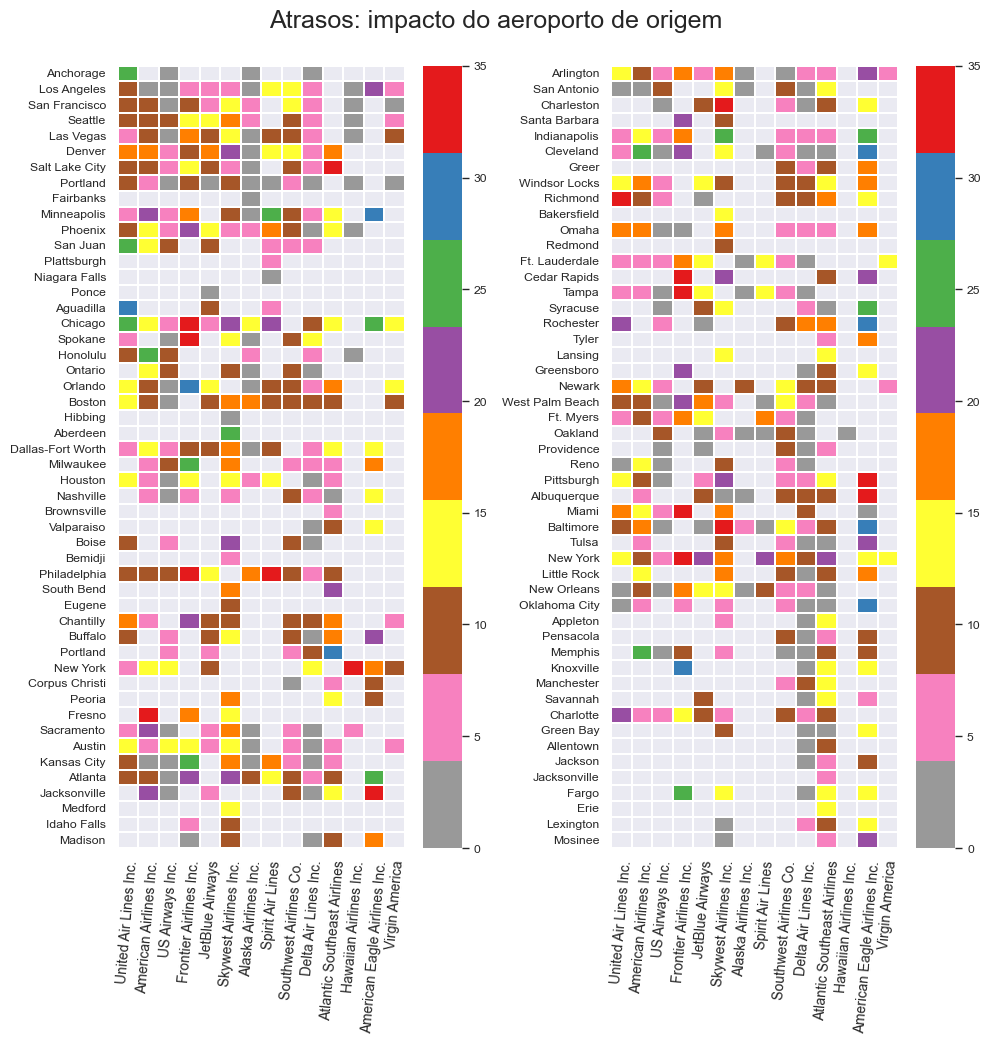

In [33]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
subset = atraso_medio_aeroporto.iloc[:50, :].rename(columns=abrev_companhias)
subset = subset.rename(index=id_aeroporto)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Set1_r", mask=mask, vmin=0,
            vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

# --

ax = fig.add_subplot(1, 2, 2)
subset = atraso_medio_aeroporto.iloc[50:100, :].rename(
    columns=abrev_companhias)
subset = subset.rename(index=id_aeroporto)
fig.text(0.5, 1.02, "Atrasos: impacto do aeroporto de origem", ha='center',
         fontsize=18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Set1_r",
            mask=mask, vmin=0, vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

plt.tight_layout()


In [34]:
# Selecionando a companhia e criando um subset do dataframe principal

comp = 'AA'
df1 = df[df['AIRLINE'] == comp][['ORIGIN_AIRPORT',
                                 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY']]

# Coletando as rotas e listando os atrasos para cara uma

trajet = dict()
for ind, col in df1.iterrows():
  if pd.isnull(col['DEPARTURE_DELAY']):
    continue
  rota = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
  if rota in trajet.keys():
    trajet[rota].append(col['DEPARTURE_DELAY'])
  else:
    trajet[rota] = [col['DEPARTURE_DELAY']]

# I transpose the dictionary in a list to sort the rotas by origins

list_trajet = []
for key, value in trajet.items():
  list_trajet.append([key, value])
list_trajet.sort()


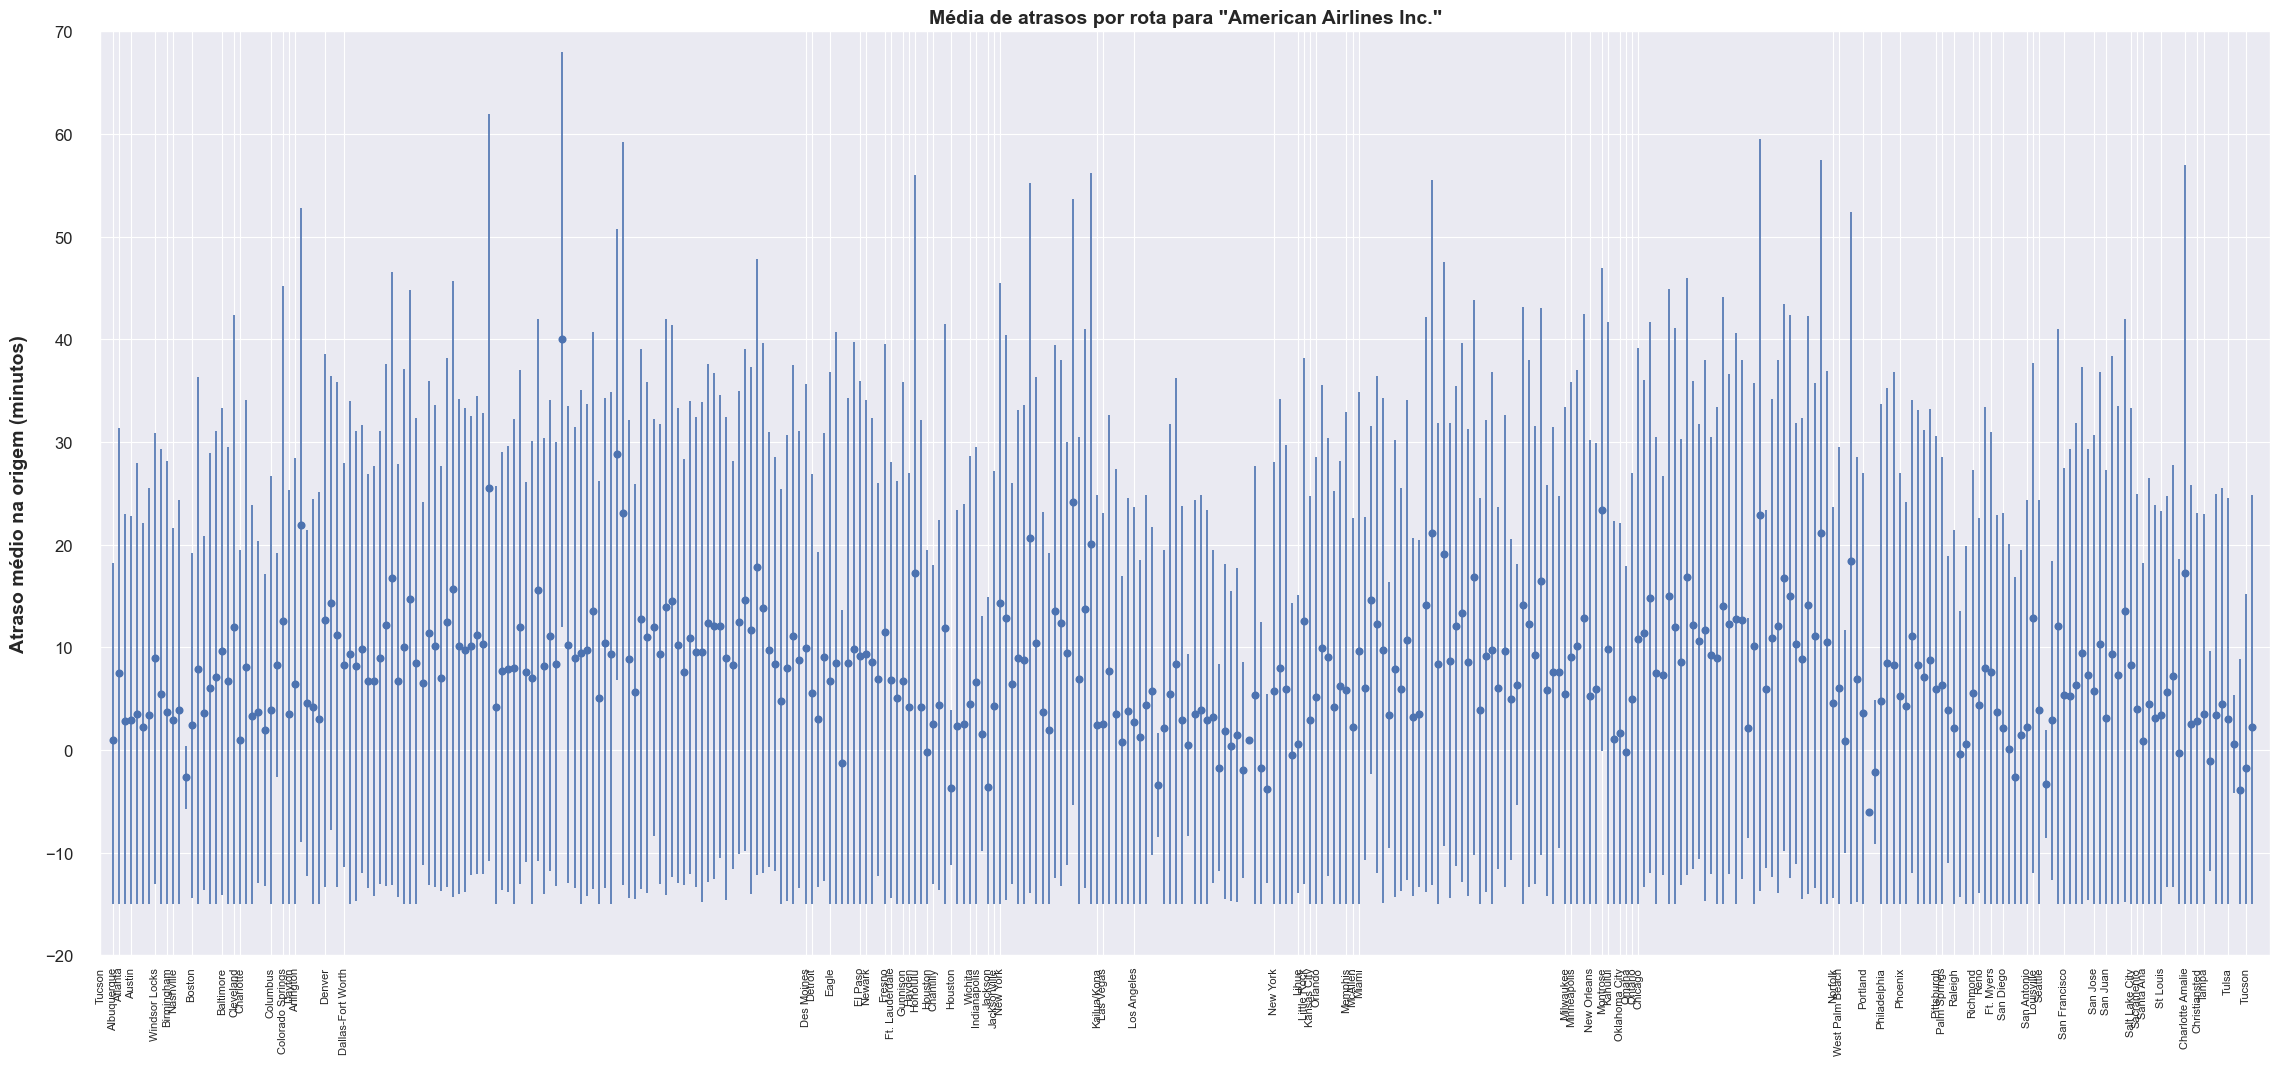

In [35]:
media_val = []
desv_pad_val = []
x_label = []

i = 0
for rota, list_atrasos in list_trajet:

    # Colocando os labels como o aeroporto de origem

    index = rota.split('-')[0]
    x_label.append(id_aeroporto[index])

    # Pondo um limite nos atrasos para impedir que valores muito altos tenham peso excessivo

    trajet2 = [min(90, s) for s in list_atrasos]

    # Calculando a média e o desvio padrão

    media_val.append(scipy.mean(trajet2))
    desv_pad_val.append(scipy.std(trajet2))
    i += 1

# Plotando o gráfico

fig, ax = plt.subplots(figsize=(28, 12))
desv_pad_min = [min(15 + media_val[i], s) for i, s in enumerate(desv_pad_val)]

ax.errorbar(list(range(i)), media_val, yerr=[
            desv_pad_min, desv_pad_val], fmt='o')
ax.set_title('Média de atrasos por rota para "{}"'.format(abrev_companhias[comp]),
             fontsize=14, weight='bold')
plt.ylabel('Atraso médio na origem (minutos)', fontsize=14, weight='bold',
           labelpad=12)

# Definindo x, y, distâncias e posições dos ticks

imin, imax = -2, 353
# Para somente uma fração, usar números entre esses limites, a exemplo do tutorial: 145,230
plt.xlim(imin, imax+2)
plt.ylim(-20, 70)

list_ticks = [imin]
for j in range(imin+1, imax):
    if x_label[j] == x_label[j-1]:
        continue
    list_ticks.append(j)

# Definindo os parâmetros dos ticks

ax.set_xticks(list_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation=90,
                   fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation=0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()


# Variabilidade temporal dos atrasos

In [36]:
class Estilo_da_figura():
    # _________________________________________________________________
    def __init__(self, size_x=11, size_y=5, nrows=1, ncols=1):
        sns.set_style("darkgrid")
        sns.set_context("notebook", font_scale=1.2,
                        rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                                     figsize=(size_x, size_y,))
    # ________________________________
    # Converter self.axs array 2D

        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
        # _____________________________

    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    # _______________

    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size=5)
    # ________________________________________

    def desenhar_legenda(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc=location, shadow=True,
                                                   facecolor='g', frameon=True)
        legend.get_frame().set_facecolor('whitesmoke')
    # ___________________________________________________________________________

    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color=color, linestyle=linestyle,
                                            linewidth=linewidth, marker=marker,
                                            label=label,
                                            markerfacecolor=markerfacecolor,
                                            markersize=markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color=color, linestyle=linestyle,
                                            linewidth=linewidth, label=label)
            self.fig.autofmt_xdate()
    # ________________________________________________________________________

    def cust_plot_date(self, x, y, color='lightblue', linestyle='-', linewidth=1,
                       markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue',
                                             markeredgecolor='grey',
                                             markeredgewidth=markeredgewidth,
                                             label=label)
    # ________________________________________________________________________

    def cust_scatter(self, x, y, color='lightblue', markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                           linewidths=markeredgewidth, label=label)
    # ___________________________________________

    def set_xlabel(self, label, fontsize=14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize=fontsize)
    # ___________________________________________

    def set_ylabel(self, label, fontsize=14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize=fontsize)
    # ____________________________________

    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    # ____________________________________

    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])


In [37]:
comp = 'WN'
id_aeroporto = 4
list_aeroporto_origem = df[df['AIRLINE'] == comp]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == comp) & (df['ARRIVAL_DELAY'] > 0)
      & (df['ORIGIN_AIRPORT'] == list_aeroporto_origem[id_aeroporto])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

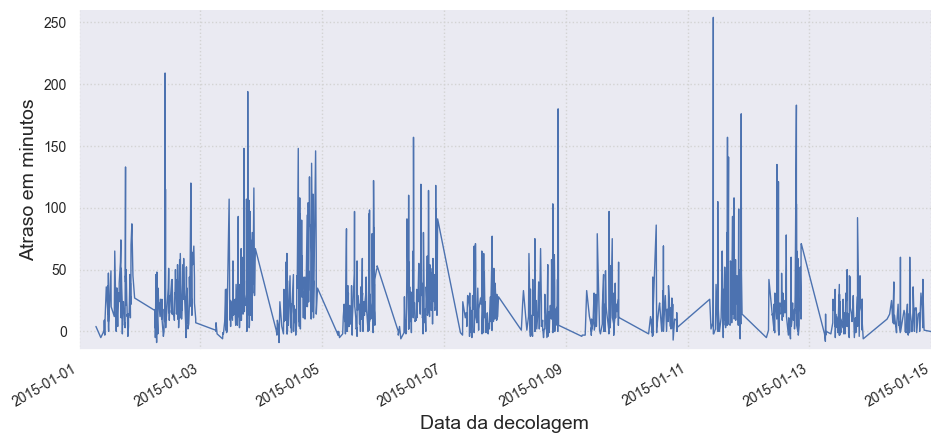

In [38]:
fig1 = Estilo_da_figura(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Atraso em minutos', fontsize = 14)
fig1.set_xlabel('Data da decolagem', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)

In [39]:
#_______________________________
def func2(x, a, b, c):
  return a * x**2 +  b*x + c

#_______________________________
df2['horario_decolagem'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())

test2 = df2['DEPARTURE_DELAY'].groupby(df2['horario_decolagem']).apply(get_stats).unstack()

fct = lambda x:x.hour*3600+x.minute*60+x.second

x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['média']

popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

In [40]:
df2.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL,horario_decolagem
760,WN,PHX,DAL,2015-01-01 06:50:00,06:54:00,4.0,10:00:00,10:04:00,4.0,130.0,130.0,0,06:50:00
2228,WN,PHX,SLC,2015-01-01 08:45:00,08:40:00,-5.0,10:20:00,10:25:00,5.0,95.0,105.0,0,08:45:00
3228,WN,PHX,LAS,2015-01-01 09:55:00,09:55:00,0.0,10:00:00,10:06:00,6.0,65.0,71.0,0,09:55:00
3317,WN,PHX,SAN,2015-01-01 10:00:00,09:59:00,-1.0,10:10:00,10:12:00,2.0,70.0,73.0,0,10:00:00
3405,WN,PHX,LIT,2015-01-01 10:05:00,10:13:00,8.0,13:35:00,13:46:00,11.0,150.0,153.0,1,10:05:00


In [41]:
# mpl.dates.date2num()
np.array(df2['horario_decolagem'])

array([datetime.time(6, 50), datetime.time(8, 45), datetime.time(9, 55),
       ..., datetime.time(19, 50), datetime.time(19, 50),
       datetime.time(19, 50)], dtype=object)

ConversionError: Failed to convert value(s) to axis units: array([datetime.time(6, 50), datetime.time(8, 45), datetime.time(9, 55),
       ..., datetime.time(19, 50), datetime.time(19, 50),
       datetime.time(19, 50)], dtype=object)

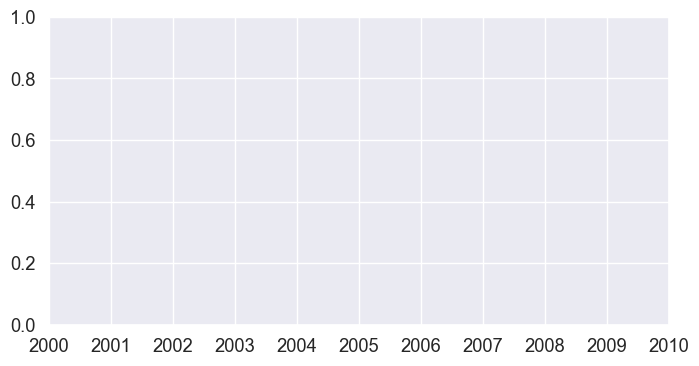

In [42]:
fig1 = Estilo_da_figura(8, 4, 1, 1)

fig1.pos_update(0, 0)

X_date = np.array(df2['horario_decolagem'])
Y_date = np.array(df2['DEPARTURE_DELAY'])

X_plot = np.array(test2.index)

fig1.cust_plot_date(X_date, Y_date,
                    markeredge=False, label='pontos de dados iniciais')
fig1.cust_plot(X_plot, test2['média'], linestyle='--', linewidth=2, label='média')
fig1.cust_plot(X_plot, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')

fig1.style()
fig1.desenhar_legenda('upper left')

fig1.set_ylabel('Atraso em minutos', fontsize = 14)
fig1.set_xlabel('Horário de decolagem', fontsize = 14)

fig1.set_ylim(-15, 210)

# Prevendo atrasos de vôos

Usar os dados das três primeiras semanas para prever os atrasos da última semana

In [43]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]

## Modelo 1: 1 companhia aérea, 1 aeroporto

Modelo que permite identificar problemas que surgiriam numa análise do dataset completo, para permitir a robustez da análise quando realizada no dataset todo.

### Problemas a se evitar

1) Estatísticas insuficientes
    
    Não permitem realizar regressão.
  

In [44]:
# Censo do número de vôos da Amerian Airlines que decolou de cada aeroporto

comp = 'AA'
checar_aeroportos = df_train[(df_train['AIRLINE'] == comp)]['DEPARTURE_DELAY'].groupby(
    df_train['ORIGIN_AIRPORT']).apply(get_stats).unstack()
checar_aeroportos.sort_values('contagem', ascending=False, inplace=True)

# Os 5 aeroportos menos visitados
checar_aeroportos[-5:]


,min,max,contagem,média
ORIGIN_AIRPORT,,,,
JAC,-19.0,47.0,25.0,-3.640000
GUC,-24.0,199.0,22.0,13.227273
SDF,-8.0,55.0,19.0,8.421053
LIT,-5.0,74.0,9.0,12.555556
MTJ,-2.0,51.0,3.0,26.000000


2) Atrasos extremos

    Atrasos extremos causados por circunstâncias imprevisíveis (como fenômenos meteorológicos, quebras ou acidentes) podem enviesar a análise.

In [45]:
# Calcula a média de vôos por companhia aérea e por aeroporto
def pegar_atrasos_voos(df_train, comp, id_aeroporto, extrem_values=False):
    df2 = df_train[(df_train['AIRLINE'] == comp) & (
        df_train['ORIGIN_AIRPORT'] == id_aeroporto)]

    # _______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(
            lambda x: x if x < 60 else np.nan)
        df2.dropna(how='any')

  # __________________________________
  # Conversão: data + horário -> horário
    df2.sort_values('SCHEDULED_DEPARTURE', inplace=True)
    df2['horario_decolagem'] = df2['SCHEDULED_DEPARTURE'].apply(
        lambda x: x.time())

    # ___________________________________________________________________
    # Reagrupamento dos vôos por horario de decolagem e cálculo da média
    test2 = df2['DEPARTURE_DELAY'].groupby(
        df2['horario_decolagem']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)

    # ___________________________________
    # Conversão do horário em segundos
    def fct(x): return x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['horario_decolagem_min'] = test2['horario_decolagem'].apply(fct)
    return test2


In [46]:
# Função que performa uma regressão linear nos valores

def regressao_linear(test2):
    test = test2[['média', 'horario_decolagem_min']].dropna(how='any', axis = 0)
    X = np.array(test['horario_decolagem_min'])
    Y = np.array(test['média'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [47]:
sns.set_style("whitegrid")

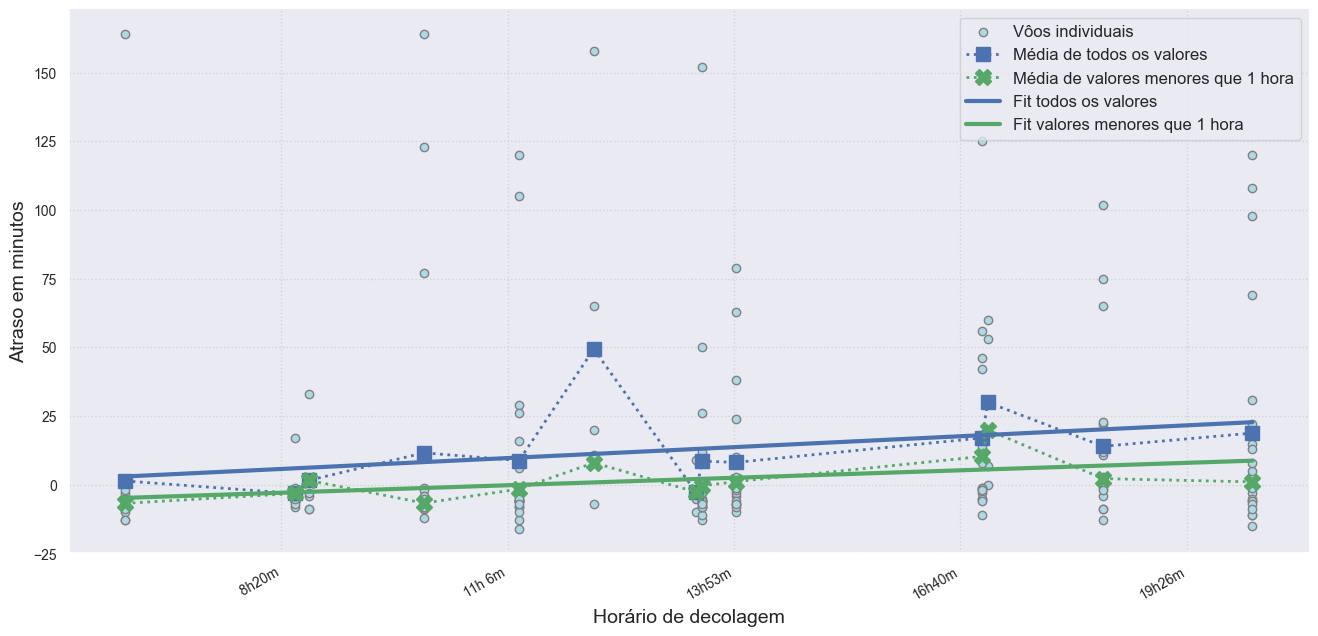

In [48]:
# 2 cenários:
  # 1) todos os valores
  # 2) eliminando atrasos maiores que 1 hora

id_aeroporto = 'PHL'
df2 = df_train[(df_train['AIRLINE'] == comp) & (df_train['ORIGIN_AIRPORT'] == id_aeroporto)]
df2['horario_decolagem'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['horario_decolagem'] = df2['horario_decolagem'].apply(lambda x:x.hour*3600+x.minute*60+x.second)

#___________________
# Primeiro cenário
test2 = pegar_atrasos_voos(df_train, comp, id_aeroporto, False)
X1, Y1, result2 = regressao_linear(test2)

#___________________
# Segundo cenário
test3 = pegar_atrasos_voos(df_train, comp, id_aeroporto, True)
X2, Y2, result3 = regressao_linear(test3)

# ----

fig1 = Estilo_da_figura(16, 8, 1, 1)

fig1.pos_update(0, 0)

fig1.cust_scatter(df2['horario_decolagem'], df2['DEPARTURE_DELAY'], markeredge = True, label="Vôos individuais")
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10), label='Média de todos os valores')
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12), label='Média de valores menores que 1 hora')

fig1.cust_plot(X1, result2, color = 'b', linewidth = 3, label='Fit todos os valores')
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3, label='Fit valores menores que 1 hora')

fig1.style()
fig1.set_ylabel('Atraso em minutos', fontsize = 14)
fig1.set_xlabel('Horário de decolagem', fontsize = 14)

#____________________________________
# Converter e setar os labels do x tick
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

L = plt.legend(fontsize=12)


## Grau polinomial: dividindo o dataset

Em vez de fazer uma simples regressão linear, o modelo pode ser melhorado fazendo um fit com um polinômio de grau *N*, sendo necessário definir o N ótimo para representar os dados.

1) Viés introduzido pela separação do dataset

    Ao dividir o dataset em train e test, viéses podem ser introduzidos, como no caso extremo em que o dataset de treinamento contenha somente horas <20h, e o dataset de teste contenha horas >20h. O modelo seria incapaz de prever corretamente.



In [49]:
class fit_polinomio:
    def __init__(self, data):
        self.data = data[['média', 'horario_decolagem_min']].dropna(
            how='any', axis=0)

    def split(self, method):
        self.method = method
        self.X = np.array(self.data['horario_decolagem_min'])
        self.Y = np.array(self.data['média'])
        self.X = self.X.reshape(len(self.X), 1)
        self.Y = self.Y.reshape(len(self.Y), 1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test = self.X
            self.Y_test = self.Y
        elif method == 'split':
            self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
                self.X, self.Y, test_size=0.3)

    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree=pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)

    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)

    def calc_score(self):
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)


A classe *fit_polinomio* permite performar todas as operações relacionadas a um fit e salvar os resultados. Ao chamar o método *split()*, a variável "method" define como os dados iniciais são separados:

- method = 'all' : todos os dados são usados para treinar e testar o modelo;
- method = 'split' : o método *train_test_split()* do sklearn é usado para definir os sets de treinamento e teste;

Os outros métodos da classe têm as seguintes funções:

- train (n) : utiliza os dados no set de treinamneto e faz uma polinomial de ordem n;
- predict (X) : calcula os Y associados com os X do input com o modelo usado anteriorimente;
- calc_score () : calcula o score do modelo com relação aos dados do set de teste

modelo nº1 , min. por n = 2, score = 13.9
modelo nº2 , min. por n = 2, score = 84.5
modelo nº3 , min. por n = 1, score = 152.3
modelo nº4 , min. por n = 3, score = 284.3


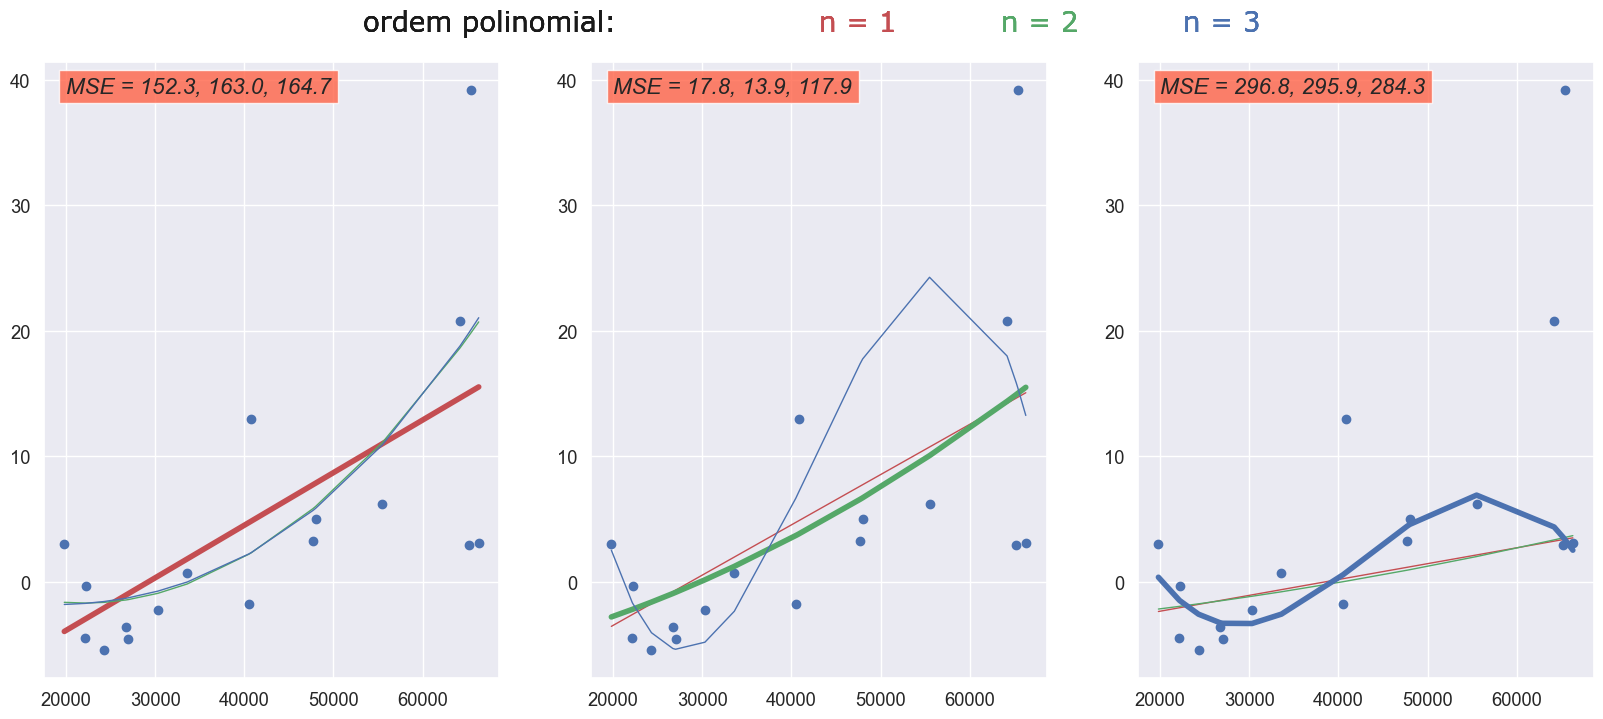

In [50]:
fig = plt.figure(1, figsize=(20, 8))

ax = ['_' for _ in range(4)]
ax[1] = fig.add_subplot(131)
ax[2] = fig.add_subplot(132)
ax[3] = fig.add_subplot(133)

id_aeroporto = 'BNA'
test2 = pegar_atrasos_voos(df, comp, id_aeroporto, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polinomio(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1, 4):
        fit.train(pol_order=i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i] = fit.score

    [ind_min] = [j for j, val in enumerate(score) if min(score) == val]
    print("modelo nº{:<2}, min. por n = {}, score = {:.1f}".format(
        inc, ind_min, score[ind_min]))

    if not found[ind_min]:
        for i in range(1, 4):
            ax[ind_min].plot(fit.X, result[i], color[i],
                             linewidth=4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize=16, bbox={'facecolor': 'tomato', 'alpha': 0.8, 'pad': 5})
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "ordem polinomial:", color='k',
             transform=ax[2].transAxes, fontsize=20, family='verdana')
    plt.text(0+shift, 1.05, "n = 1", color='r',
             transform=ax[2].transAxes, fontsize=20, family='verdana')
    plt.text(0.4+shift, 1.05, "n = 2", color='g',
             transform=ax[2].transAxes, fontsize=20, family='verdana')
    plt.text(0.8+shift, 1.05, "n = 3", color='b',
             transform=ax[2].transAxes, fontsize=20, family='verdana')

    if inc == 40 or all(found[1:4]):
        break


2) Seleção por cross-validation

    Uma das vantagens de cross-validation é que evita o viés introduzido quando escolhendo o grau polinomial.

In [51]:
class fit_polinomio_cv:

    def __init__(self, data):
        self.data = data[['média', 'horario_decolagem_min']].dropna(
            how='any', axis=0)
        self.X = np.array(self.data['horario_decolagem_min'])
        self.Y = np.array(self.data['média'])
        self.X = self.X.reshape(len(self.X), 1)
        self.Y = self.Y.reshape(len(self.Y), 1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree=pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(
            self.regr, self.X_, self.Y, cv=nb_folds)

    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree=pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv=nb_folds, scoring='neg_mean_squared_error'))


Essa classe tem 2 métodos:

- train (pol_order, nb_folds) : definidos "nb_folds" sets de treinamento a partir do dataset inicial, faz uma polinomial de ordem "pol_order" em cada um desses sets. Retorna as previsões Y obtidas para os diferentes sets de teste como resultado.
- calc_score (pol_order, nb_folds) : executa o mesmo procedimento que o método train(), mas retorna o fit score e não os valores preditos nos diferntes dados de teste.

Por default, o método "k-fold" é usado pelos métodos "cross_val_predict()" e "cross_val_score()" do sklearn. Esses métodos são determinísticos na escolha dos K folds, o que implica que para um valor K fixado, os resultos obtidos por esses métodos serão sempre idênticos, o que não era o caso quando usando o método "train_test_split()". Desse modo, o método de cross validation torna possível escolher o melhor grau polinomial.


In [52]:
# id_aeroporto = 1129804 
nb_folds = 10
print('Máximo número de folds possível: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polinomio_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Máximo número de folds possível: 16 

n=1 -> MSE = 149.662
n=2 -> MSE = 172.241
n=3 -> MSE = 181.343
n=4 -> MSE = 185.287
n=5 -> MSE = 190.5
n=6 -> MSE = 197.815
n=7 -> MSE = 207.827


In [53]:
fit = fit_polinomio(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

In [54]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

[Text(10000.0, 0, ' 2h46m'),
 Text(20000.0, 0, ' 5h33m'),
 Text(30000.0, 0, ' 8h20m'),
 Text(40000.0, 0, '11h 6m'),
 Text(50000.0, 0, '13h53m'),
 Text(60000.0, 0, '16h40m'),
 Text(70000.0, 0, '19h26m')]

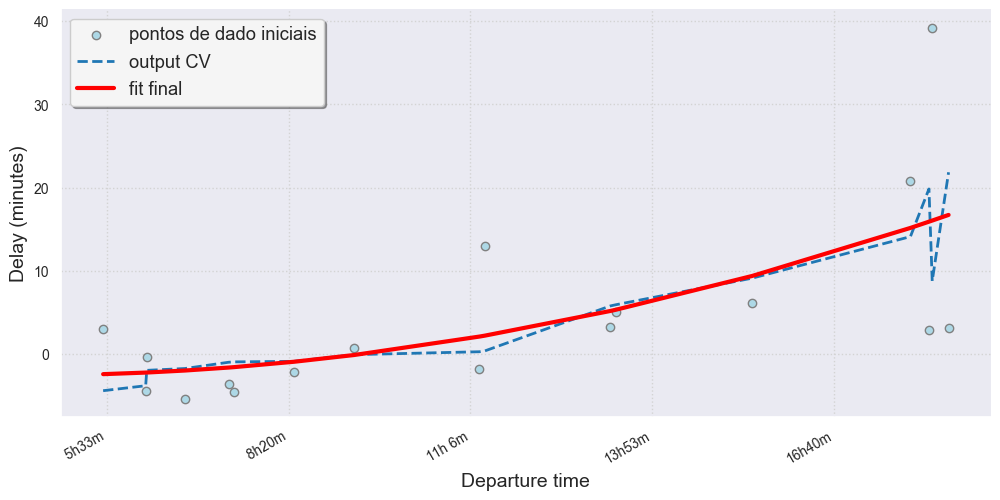

In [55]:
fig1 = Estilo_da_figura(12, 6, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge=True, label='pontos de dado iniciais')
fig1.cust_plot(fit.X, fit2.result, color=u'#1f77b4',
               linestyle='--', linewidth=2, label='output CV')
fig1.cust_plot(fit.X, fit.result, color=u'red',
               linewidth=3, label='fit final')
fig1.style()
fig1.desenhar_legenda('upper left')
fig1.set_ylabel('Delay (minutes)')
fig1.set_xlabel('Departure time')
# ____________________________________
# convert and set the x ticks labels
def fct_convert(x): return (int(x/3600), int(divmod(x, 3600)[1]/60))


fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()])


In [56]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

66.58655898909323

## Teste do modelo: predição de atrasos no fim de janeiro

In [57]:
test_data = pegar_atrasos_voos(df_test, comp, id_aeroporto, True)
test_data = test_data[['média', 'horario_decolagem_min']].dropna(
    how='any', axis=0)
X_test = np.array(test_data['horario_decolagem_min'])
Y_test = np.array(test_data['média'])
X_test = X_test.reshape(len(X_test), 1)
Y_test = Y_test.reshape(len(Y_test), 1)
fit.predict(X_test)


In [58]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

89.28481193452785

In [59]:
'Diferença entre atraso previsto e atraso real = {:.2f} min'.format(np.sqrt(score))

'Diferença entre atraso previsto e atraso real = 9.45 min'

# Modelo 2: 1 companhia, todos os aeroportos

In [60]:
def get_merged_delays(df, comp):
    list_aeroportos = df[df['AIRLINE'] == comp]['ORIGIN_AIRPORT'].unique()
    i = 0
    list_colunas = ['AIRPORT_ID', 'horario_decolagem_min', 'média']
    for id_aeroporto in list_aeroportos:
        test2 = pegar_atrasos_voos(df, comp, id_aeroporto, True)
        test2.loc[:, 'AIRPORT_ID'] = id_aeroporto
        test2 = test2[list_colunas]
        test2.dropna(how='any', inplace=True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index=True)
        i += 1
    return merged_df


In [61]:
comp = 'AA'
merged_df = get_merged_delays(df, comp)
merged_df.shape

(1831, 3)

In [62]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])

# __________________________________________________________
# correspondência entre os códigos e as tags dos aeroportos

zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_aeroportos = list(set(list(zipped)))
label_aeroportos.sort(key=lambda x: x[0])
label_aeroportos[:5]


[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [63]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['horario_decolagem_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['média'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1831, 82) (1831, 1)


## Regressão linear

In [64]:
lm = linear_model.LinearRegression()
model = lm.fit(X, Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))


MSE = 53.74199146108669


In [65]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15:
        icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)


'5.19%'

Tende a subestimar grandes atrasos

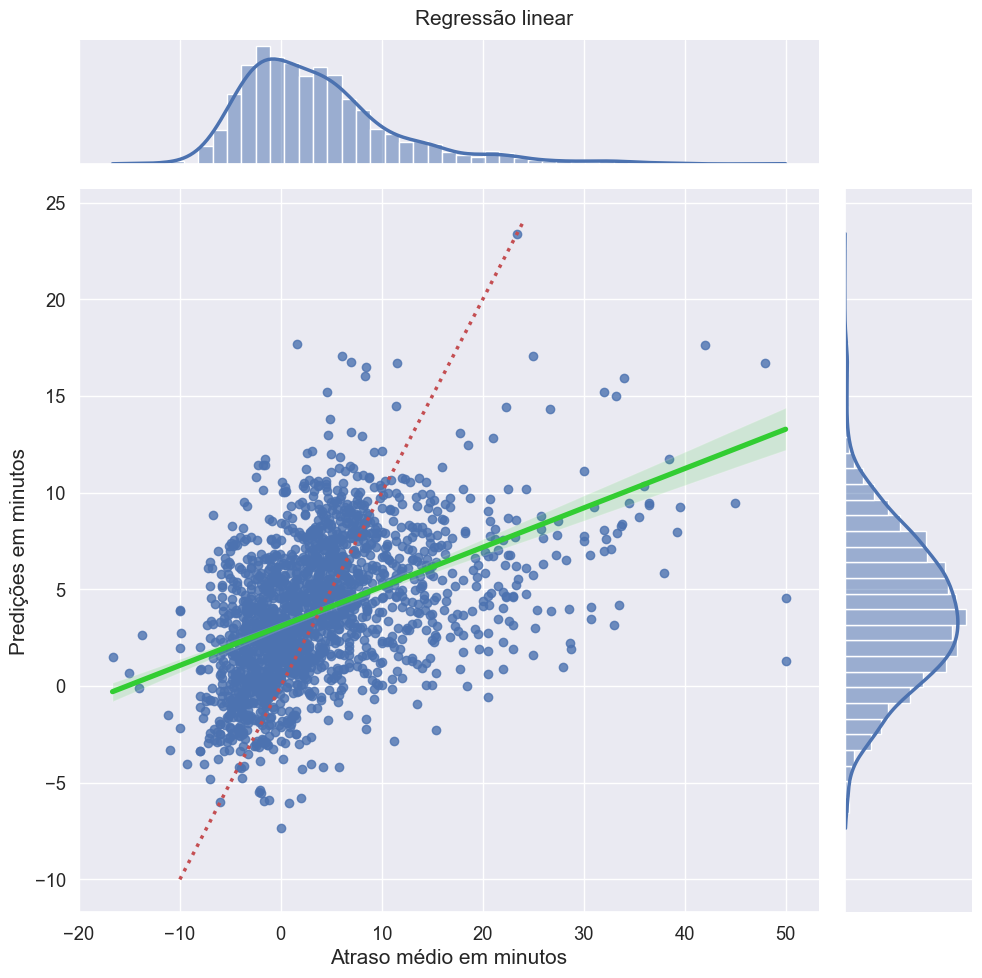

In [66]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions])
tips["original_data"] = pd.Series([float(s) for s in Y])
grafico = sns.jointplot(x="original_data", y="prediction", data=tips, size=10,
                        ratio=5, joint_kws={'line_kws': {'color': 'limegreen'}},
                        kind='reg')

grafico.ax_joint.set_xlabel('Atraso médio em minutos', fontsize=15)
grafico.ax_joint.set_ylabel('Predições em minutos', fontsize=15)

grafico.ax_joint.plot(list(range(-10, 25)), list(range(-10, 25)), linestyle=':',
                       color='r')

plt.suptitle('Regressão linear', fontsize=15)
grafico.fig.subplots_adjust(top=0.95)

plt.show()


## Regressão polinomial

In [67]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression()

In [68]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 49.51242308901972


In [69]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15:
        icount += 1
'{:.2f}%'.format(icount / len(result) * 100)


'5.08%'

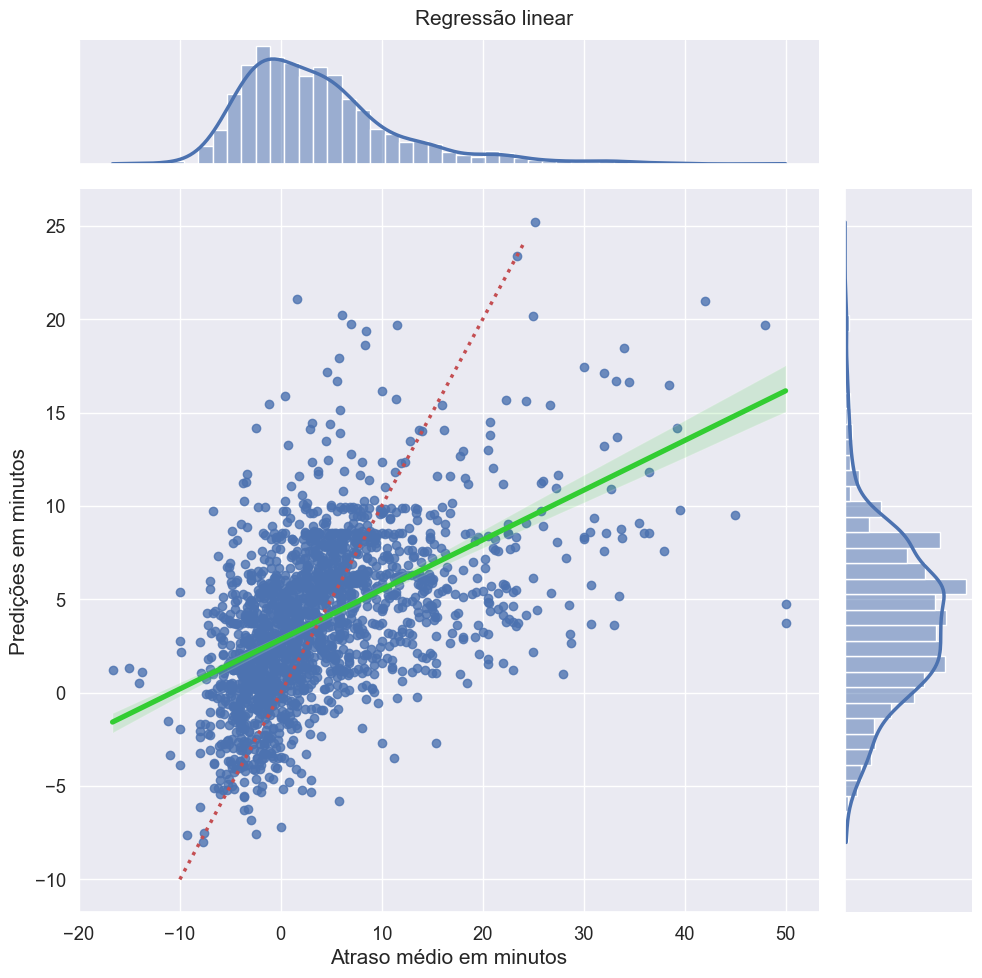

In [70]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result])
tips["original_data"] = pd.Series([float(s) for s in Y])

grafico2 = sns.jointplot(x="original_data", y="prediction", data=tips, size=10,
                         ratio=5, joint_kws={'line_kws': {'color': 'limegreen'}},
                         kind='reg')

grafico2.ax_joint.set_xlabel('Atraso médio em minutos', fontsize=15)
grafico2.ax_joint.set_ylabel('Predições em minutos', fontsize=15)
grafico2.ax_joint.plot(list(range(-10, 25)), list(range(-10, 25)), linestyle=':',
                       color='r')

plt.suptitle('Regressão polinomial', fontsize=15)
grafico2.fig.subplots_adjust(top=0.95)

plt.show()


### Definindo os parâmetros livres

Os dois modelos acima foram fitados e testados no set de treinamento. Há um risco de overfitting, de modo que os parâmetros livres serão enviesados. Desse modo, o modelo não permitirá uma boa generalização.

A seguir, os dados serão separados de modo a treinar e testar o modelo, a fim de determinar o grau polinomial que permite a melhor generalização das predições.

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [72]:
X_train.shape

(1281, 82)

In [73]:
poly = PolynomialFeatures(degree=2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("MSE = ", score)


MSE =  44.13971515326513


In [74]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("MSE = ", score)


MSE =  6373.64095725386


Péssimo resultado! É necessário investigar a fundo. Primeiro, vale a pena olhar os termos de MSE separadamente.

In [75]:
soma = 0
for valores in zip(result, Y_test):
    acrescimo = (float(valores[0]) - float(valores[1]))**2
    soma += acrescimo
    if acrescimo > 10**4:
        print("acrescimo:{:<.1f} | valores[0]:{:<.1f} | valores[1]:{:<.1f}".format(
            acrescimo, float(valores[0]), float(valores[1])))


acrescimo:93611.0 | valores[0]:312.2 | valores[1]:6.2
acrescimo:1252837.7 | valores[0]:-1089.3 | valores[1]:30.0
acrescimo:80656.7 | valores[0]:307.4 | valores[1]:23.4
acrescimo:217750.2 | valores[0]:466.0 | valores[1]:-0.6
acrescimo:97086.9 | valores[0]:310.1 | valores[1]:-1.5
acrescimo:1280222.1 | valores[0]:-1125.7 | valores[1]:5.8
acrescimo:203942.8 | valores[0]:-457.6 | valores[1]:-6.0
acrescimo:236654.7 | valores[0]:-472.1 | valores[1]:14.3


Algumas predições apresentam erros muito grandes. Na prática, isso pode ser explicado pelo fato de que durante a separação em sets de train e teste, **dados sem um equivalente no set de treinamento foram colocados no set de teste**. Desse modo, quando calculando a predição, o modelo precisou **fazer uma extrapolação**.

Se os coeficientes do fit são grandes (o que frequentemente é o caso quando ocorre overfitting), valores extrapolados serão de grande importância, como no caso atual.

De modo a ter controle sobre esse fenômeno, pode-se usar um **método de regularização** que colocará uma penalidade para os modelos cujos coeficientes são os de maior importância.

In [76]:
from sklearn.linear_model import Ridge

ridgereg = Ridge(alpha=0.3, normalize=True)
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)


Ridge(alpha=0.3, normalize=True)

In [77]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("MSE = ", score)


MSE =  71.81704560561542


Um resultado razoável.

Desse modo, no atual procedimento de determinar o melhor modelo, há dois parâmetros livres a serem ajustados: o grau polinomial e o coeficiente $\alpha$ da regressão de ridge

In [78]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha=alpha/10, normalize=True)
        poly = PolynomialFeatures(degree=pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} | alpha={} || MSE = {:<0.5}".format(pol_order, alpha, score))


n=1 | alpha=0 || MSE = 5.579e+25
n=1 | alpha=2 || MSE = 69.722
n=1 | alpha=4 || MSE = 68.704
n=1 | alpha=6 || MSE = 68.185
n=1 | alpha=8 || MSE = 67.929
n=1 | alpha=10 || MSE = 67.82
n=1 | alpha=12 || MSE = 67.796
n=1 | alpha=14 || MSE = 67.822
n=1 | alpha=16 || MSE = 67.876
n=1 | alpha=18 || MSE = 67.948
n=2 | alpha=0 || MSE = 93.892
n=2 | alpha=2 || MSE = 72.291
n=2 | alpha=4 || MSE = 71.465
n=2 | alpha=6 || MSE = 70.929
n=2 | alpha=8 || MSE = 70.522
n=2 | alpha=10 || MSE = 70.204
n=2 | alpha=12 || MSE = 69.951
n=2 | alpha=14 || MSE = 69.748
n=2 | alpha=16 || MSE = 69.585
n=2 | alpha=18 || MSE = 69.453


É importante ressaltar que para o caso atual, as estimativas obtidas com uma regressão linear ou polinomial são muito próximas.

In [79]:
ridgereg = Ridge(alpha=parameters[0], normalize=True)
poly = PolynomialFeatures(degree=parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)
print(score)


57.73209091265273


### Testando o modelo: atrasos do fim de janeiro

In [80]:
comp = 'AA'
merged_df_test = get_merged_delays(df_test, comp)


In [81]:
label_conversao = dict()
for s in label_aeroportos:
    label_conversao[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversao, inplace=True)

for index, label in label_aeroportos:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x: 1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['horario_decolagem_min'])
b = b.reshape(len(b), 1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['média'])
Y_test = Y_test.reshape(len(Y_test), 1)


In [82]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)


'MSE = 49.91'

In [83]:
'Diferença entre atraso previsto e atraso real = {:.2f} min'.format(np.sqrt(score))

'Diferença entre atraso previsto e atraso real = 7.06 min'

## Modelo 3: contabilizando os destinos

No modelo anterior, vôos estavam agrupados pelo horário de decolagem. Desse modo, vôos com destinos diferentes foram agrupados se tivessem o mesmo horário de decolagem.

O próximo modelo leva em conta ambos horários de decolagem e de pouso.

In [84]:
def create_df(df, comp):
    df2 = df[df['AIRLINE'] == comp][['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
                                     'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY']]
    df2.dropna(how='any', inplace=True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())

    # ____________________
    # retirar atrasos > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(
        lambda x: x if x < 60 else np.nan)
    df2.dropna(how='any', inplace=True)

    # _________________
    # formatando horarios
    def fct(x): return x.hour*3600+x.minute*60+x.second
    df2['horario_decolagem'] = df2['SCHEDULED_DEPARTURE'].apply(
        lambda x: x.time())
    df2['horario_decolagem'] = df2['horario_decolagem'].apply(fct)
    df2['horario_pouso'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['horario_decolagem', 'horario_pouso', 'ORIGIN_AIRPORT'],
                      as_index=False).mean()
    return df3


In [85]:
df3 = create_df(df, comp)    
df3[:5]

,horario_decolagem,horario_pouso,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,0.041667,3.00
1,300,17700,LAX,5.500000,3.75
2,600,28200,LAX,-6.000000,3.25
3,1200,29040,LAX,-1.538462,3.00
4,1200,29100,LAX,0.800000,3.60


In [86]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])

# _________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_aeroportos = list(set(list(zipped)))
label_aeroportos.sort(key=lambda x: x[0])

# _________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# _________________________________________________
b = np.array(df3[['horario_decolagem', 'horario_pouso']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)


### Escolha dos parâmetros do modelo

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [89]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha=alpha/10, normalize=True)
        poly = PolynomialFeatures(degree=pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)

        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)

        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} | alpha={} || MSE = {:<0.5}".format(pol_order, alpha, score))


n=1 | alpha=0 || MSE = 93.089
n=1 | alpha=2 || MSE = 92.524
n=1 | alpha=4 || MSE = 92.767
n=1 | alpha=6 || MSE = 93.289
n=1 | alpha=8 || MSE = 93.93
n=1 | alpha=10 || MSE = 94.61
n=1 | alpha=12 || MSE = 95.29
n=1 | alpha=14 || MSE = 95.95
n=1 | alpha=16 || MSE = 96.581
n=1 | alpha=18 || MSE = 97.178
n=2 | alpha=0 || MSE = 130.93
n=2 | alpha=2 || MSE = 93.174
n=2 | alpha=4 || MSE = 93.058
n=2 | alpha=6 || MSE = 93.04
n=2 | alpha=8 || MSE = 93.07
n=2 | alpha=10 || MSE = 93.136
n=2 | alpha=12 || MSE = 93.232
n=2 | alpha=14 || MSE = 93.352
n=2 | alpha=16 || MSE = 93.491
n=2 | alpha=18 || MSE = 93.646


In [90]:
ridgereg = Ridge(alpha=parameters[0], normalize=True)
poly = PolynomialFeatures(degree=parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)
print(score)


85.97465831285838


### Teste do modelo: atrasos do fim de janeiro

In [91]:
df3 = create_df(df_test, comp)    
df3[:5]

,horario_decolagem,horario_pouso,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,-4.000,3.25
1,1200,29040,LAX,5.125,3.25
2,1800,20340,SFO,-6.750,3.25
3,2700,29340,LAS,-4.500,3.25
4,3900,31800,LAX,-4.875,3.25


In [92]:
label_conversao = dict()
for s in label_aeroportos:
    label_conversao[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversao, inplace=True)

for index, label in label_aeroportos:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x: 1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['horario_decolagem', 'horario_pouso']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)


In [93]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))


MSE = 68.42


In [94]:
'Diferença entre atraso previsto e atraso real = {:.2f} min'.format(np.sqrt(score))


'Diferença entre atraso previsto e atraso real = 8.27 min'

In [95]:

icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15:
        icount += 1
print("diferenças > 15 minutos: {}%".format(
    round((icount / len(predictions))*100, 3)))


diferenças > 15 minutos: 4.096%


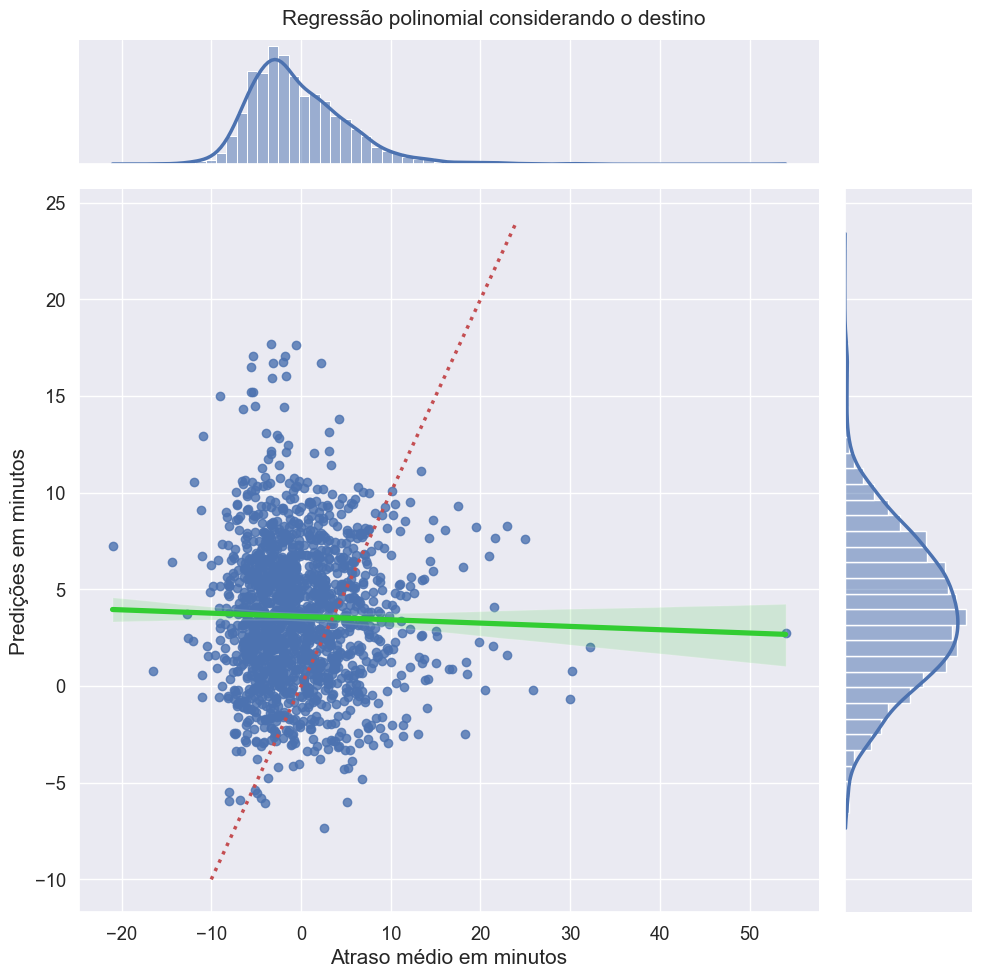

In [96]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions])
tips["original_data"] = pd.Series([float(s) for s in Y_test])


grafico3 = sns.jointplot(x="original_data", y="prediction", data=tips, size=10,
                         ratio=5, joint_kws={'line_kws': {'color': 'limegreen'}}, 
                         kind='reg')

grafico3.ax_joint.set_xlabel('Atraso médio em minutos', fontsize=15)
grafico3.ax_joint.set_ylabel('Predições em minutos', fontsize=15)
grafico3.ax_joint.plot(list(range(-10, 25)), list(range(-10, 25)), linestyle=':',
                       color='r')

plt.suptitle('Regressão polinomial considerando o destino', fontsize=15)
grafico3.fig.subplots_adjust(top=0.95)

plt.show()
